<a href="https://colab.research.google.com/github/jmestanza/PASA_TP1_Echo_cancellation/blob/master/FastBlockLMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" Example for computing the RIR between several sources and receivers in GPU.
"""
!pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from math import ceil

import gpuRIR

     | 2.7MB 1.1MB/s
  Created wheel for gpuRIR: filename=gpuRIR-1.2.0-cp36-cp36m-linux_x86_64.whl size=907218 sha256=aaa3fa82b18e7bb39f390a341bd49798caead12b7268e65189aa2b2b1f2d2910
  Stored in directory: /tmp/pip-ephem-wheel-cache-s60sz8eu/wheels/d6/80/3f/6af7d0e500b38d174f793d6b8ff6a0984b1eab8b2c8f6665ae
Successfully built gpuRIR


     \ 2.7MB 557kB/s
  Created wheel for gpuRIR: filename=gpuRIR-1.2.0-cp36-cp36m-linux_x86_64.whl size=907218 sha256=a8b5b09bd78ca79a9a57683026f719fdfd6830696fe0eff223da3f4c71741aba
  Stored in directory: /tmp/pip-ephem-wheel-cache-z168b8f7/wheels/d6/80/3f/6af7d0e500b38d174f793d6b8ff6a0984b1eab8b2c8f6665ae
Successfully built gpuRIR


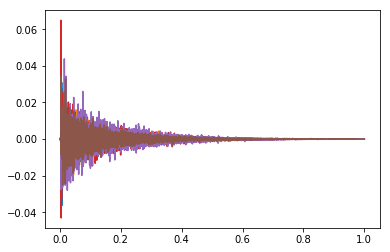

In [0]:

gpuRIR.activateMixedPrecision(False)

room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 2  # Number of sources
pos_src = np.array([[1,2.9,0.5],[1,2,0.5]]) # Positions of the sources ([m]
nb_rcv = 3 # Number of receivers
pos_rcv = np.array([[0.5,1,0.5],[1,1,0.5],[1.5,1,0.5]])	 # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) # Vectors pointing in the same direction than the receivers
mic_pattern = "card" # Receiver polar pattern
abs_weights = [0.9]*5+[0.5] # Absortion coefficient ratios of the walls
T60 = 1.0	 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
fs=16000.0 # Sampling frequency [Hz]

beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

t = np.arange(int(ceil(Tmax * fs))) / fs
plt.plot(t, RIRs.reshape(nb_src*nb_rcv, -1).transpose())
plt.show()

In [1]:
from IPython.display import clear_output

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/music_original.wav"

!pip install -U pip setuptools
!ls
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from scipy import linalg
from scipy import signal
from scipy.io.wavfile import write

def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos

def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo p
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Estimo la energia de d
    s2d = np.var(d)
    return r,p,s2d

def get_filter(rx,p,M,sigma2d):
    rx1=rx[0:M]
    p1=p[0:M]
    R = toeplitz(rx1)
# se obtienen los coeficientes wo
    wo = np.dot(linalg.inv(R), p1)
    Jmin = sigma2d - p1.dot(wo)
    return rx1,R,p1,wo,Jmin

def read_wavs(audio_file,grab_file):
    file_name = grab_file
    fs, grab_audio = get_mono_array(file_name)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio = grab_audio - np.mean(grab_audio)
    print("fs de la grabacion ",fs, "nombre", file_name)

    file_name = audio_file
    fs, audio = get_mono_array(file_name)

    audio /= np.max(np.abs(audio),axis=0)
    audio = audio-np.mean(audio)
    print("fs del audio ",fs, "nombre", file_name)
    return audio,grab_audio,fs

signals = {'lin':['/content/sweep_rapido.wav','/content/grab_sweep_rapido.wav',0.336,7.977],
          'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936],
          'square':['/content/cuadrada.wav','/content/grab_cuadrada.wav',0.341,7.345],
          'noise':['/content/ruido_blanco_c.wav','/content/grab_ruido_blanco.wav',0.665, 8.339],
          'voice':['/content/voice_48k.wav','/content/grab_voice.wav',0.636,5.070],
          'music':['/content/music_original.wav','/content/grab_cassiopeia.wav',0.364,7.971]}

sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
r1,R,p1,wo,Jmin = get_filter(r,p,100,sigma2d)
estimado = signal.filtfilt(wo,[1],u)

FileNotFoundError: ignored

In [2]:
#plt.plot(wo)

#auxUz = uz[]

import numpy as np
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos

def NLMS(M, mu, delta, u, d):
    w = np.zeros((M,len(u)))
    e = np.zeros(len(u))
    u_star = np.zeros(M-1)
    uaux = np.concatenate((u_star, u), axis=None)
    y = np.zeros(len(u))
    energias_u = []
    
    for i in range(0,len(u)):
        if i == 0:
            e[0] = d[0] 
            y[0] = 0
            w[:,i]=np.zeros(M)
        else:
            y[i] = np.dot(w[:,i-1].conj().transpose(),uaux[i:i+M])
            e[i] = d[i]-y[i]
            energias_u.append(np.dot(uaux[i:i+M],uaux[i:i+M]))
            nu = mu/(np.dot(uaux[i:i+M],uaux[i:i+M]) + delta)
            w[:,i] = w[:,i-1] + nu *  uaux[i:i+M] * (e[i].conj())
    return w, np.power(e,2)/len(e), y, np.array(energias_u)






auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]
auxdz = dZ[len(dZ)//2:len(dZ)//2+1000]

mu = 1
delta = 1
its = 10
M = 10

w, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))


plt.plot(y)
plt.plot(np.flip(auxdz))



NameError: ignored

In [0]:
n, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de las energías de u')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)



In [50]:
u = 1+np.arange(30) # [u(0), u(1), ... ]

def getBlock(M,u):
    block = np.zeros((M,M))
    for i in range(0,M):
        block[:,i] = np.flip(u[i:i+M])
    return block

def FastBlockLMS(M, u):
    N = 2*M
    w = np.zeros(N)
    u = np.concatenate((np.zeros(M-1),u), axis= None)
    
    number_of_blocks = len(u)//(2*M-1)
    u = u[:(2*M-1)*number_of_blocks] # me quedo con el arreglo que se puede dividir en numero entero de bloques
    samples = np.split(u,number_of_blocks) # divido a u en k intervalos
    print(samples)
    
    blocks = []
    for i in range(number_of_blocks):
        block = getBlock(M,samples[i])
        blocks.append(block) 
        print(block)
    
    
    #print(block)
    # con L = M , necesito 2M+1 muestras por cada bloque

FastBlockLMS(3,u)

[array([0., 0., 1., 2., 3.]), array([4., 5., 6., 7., 8.]), array([ 9., 10., 11., 12., 13.]), array([14., 15., 16., 17., 18.]), array([19., 20., 21., 22., 23.]), array([24., 25., 26., 27., 28.])]
[[1. 2. 3.]
 [0. 1. 2.]
 [0. 0. 1.]]
[[6. 7. 8.]
 [5. 6. 7.]
 [4. 5. 6.]]
[[11. 12. 13.]
 [10. 11. 12.]
 [ 9. 10. 11.]]
[[16. 17. 18.]
 [15. 16. 17.]
 [14. 15. 16.]]
[[21. 22. 23.]
 [20. 21. 22.]
 [19. 20. 21.]]
[[26. 27. 28.]
 [25. 26. 27.]
 [24. 25. 26.]]
